# 라이브러리 임포트

In [4]:
from bs4 import BeautifulSoup
from selenium import webdriver
import requests
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import OpenDartReader
import os

In [33]:
api_key = '31718c7bf232574ee78e6f3f81c922043baad322'
dart = OpenDartReader(api_key)

set_matplotlib_formats('retina')
pd.options.display.max_rows = 50
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus = False)

pd.options.display.max_rows = 200

headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36'}
options = webdriver.ChromeOptions()
options.headless = True
options.add_argument('window-size=1920x1080')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36')

#  opendart 이용, 보고서 이름과 rcept_no, 회사 이름 리스트 형식 변환

In [35]:
dart_list = dart.list('032830', start='1999-01-01', kind='A')
print(dart_list.head(1))

report_type_dict = {
    '사업보고서':'A001',
    '반기보고서':'A002',
    '분기보고서':'A003',
}

data_size = 5 # 몇 기간의 데이터를 가져올 건지 결정
report_type_selected = list(report_type_dict.keys())[1] # 1 : 반기보고서
report_type_selected

  corp_code corp_name stock_code corp_cls        report_nm        rcept_no  \
0  00126256      삼성생명     032830        Y  분기보고서 (2020.09)  20201116001777   

  flr_nm  rcept_dt rm  
0   삼성생명  20201116     


'반기보고서'

In [36]:
dart_list = dart_list[['corp_name','report_nm','rcept_no']]
dart_list_selected = dart_list[dart_list['report_nm'].str.contains(report_type_selected)].copy()
dart_list_selected.head(1)

,corp_name,report_nm,rcept_no
1,삼성생명,반기보고서 (2020.06),20200814002158


In [37]:
corp_nms = list(dart_list_selected['corp_name'])
corp_nm = corp_nms[0] # 회사 이름 : 삼성생명

report_nms = list(dart_list_selected['report_nm'])
report_nm = report_nms[0] # 리포트 이름 : 반기보고서 (2020.09)

rcept_nos = list(dart_list_selected['rcept_no'])

In [38]:
date_list = list(dart_list_selected['report_nm'].str.split(' ').str[-1])

date_list_mod=[]

for i, val in enumerate(date_list):
    date = date_list[i].replace('(','').replace(')','')
    date_list_mod.append(date)

In [39]:
df_date = pd.Series(date_list_mod)

# url 딕셔너리 설정

In [114]:
urls = []

for rcpNo in rcept_nos:
    url = 'http://dart.fss.or.kr/dsaf001/main.do?rcpNo={}'.format(rcpNo)

    params = {
        'crtfc_key' : '31718c7bf232574ee78e6f3f81c922043baad322',
        'corp_code' : '032830',
        'bgn_de' : '19990101',
        'pblntf_detail_ty': '{}'.format(report_type_dict[report_type_selected]),
        'page_count': '100',
    }

    res = requests.get(url,params=params, headers = headers)
    res.raise_for_status()
    
    urls.append(res.url)

# 제무제표 데이터 추출

## 재무제표 파일 다운로드하는 data_to_csv 함수 만들기

### selenium 활용

In [115]:
def data_to_csv(urls):
    for i, url in enumerate(urls):
        browser = webdriver.Chrome(options = options)
        browser.maximize_window()
        browser.get(url)

        browser.find_element_by_xpath('//*[@id="ext-gen10"]/div/li[5]/ul/li[2]/div/a/span').click()
        iframes = browser.find_elements_by_tag_name('iframe')
        browser.switch_to.frame(iframes[0])
        html = browser.page_source

        report_nm = report_nms[i]
        tables = pd.read_html(html)

        df_list= list()

        for idx, v in enumerate(tables):
            if idx in [0,2,4,6]:
                pass
            else:
                df = tables[idx]
                df_list.append(df)

            for index, value in enumerate(df_list):
                if index == 0:
                    df_nm = '연결 재무상태표'
                elif index == 1:
                    df_nm = '연결 포괄손익계산서'
                elif index == 2:
                    df_nm = '자본변동표'
                else:
                    df_nm = '현금흐름표'

                df_list[index].to_csv(f'{df_nm} {corp_nm} {report_nm}.csv', encoding='utf-8-sig')
    browser.quit()

### url 사이즈 선택

In [116]:
urls = urls[:data_size]
data_to_csv(urls)

# 재무제표 데이터 수정, 병합, 통합 파일 저장

## merge 위해 데이터 수정

In [117]:
search_df_nm = '포괄손익계산서'

data_list = os.listdir()

match_list = list()

for df_nm in data_list:
    if search_df_nm in df_nm:
        match_list.append(df_nm)
        
match_list      

['연결 포괄손익계산서 삼성생명 반기보고서 (2016.06).csv',
 '연결 포괄손익계산서 삼성생명 반기보고서 (2017.06).csv',
 '연결 포괄손익계산서 삼성생명 반기보고서 (2018.06).csv',
 '연결 포괄손익계산서 삼성생명 반기보고서 (2019.06).csv',
 '연결 포괄손익계산서 삼성생명 반기보고서 (2020.06).csv']

## 데이터 merge 및 merge 파일 저장

In [118]:
df_list = list()

for i, df_nm in enumerate(match_list):
    df = pd.read_csv('./{}'.format(df_nm), encoding='utf-8-sig')
    df = df.iloc[:,1:3]
    df = df[df['과 목'].notnull()]
    df['과 목'] = df['과 목'].str.strip()
    df['과 목'] = df['과 목'].str.split('.').str[-1]
    df['과 목'] = df['과 목'].str.split('(').str[0].copy()
    df.rename(columns = {'과 목' : '계정과목'}, inplace = True)
    df_list.append(df)

### colunm to index

In [119]:
df_list_index = list()

for i, val in enumerate(df_list):
    df_index = df_list[i].set_index('계정과목').copy()
    df_list_index.append(df_index)

### merge 적용

In [120]:
for i, val in enumerate(df_list_index):
    if i == 0:
        df_merge = pd.merge(df_list_index[i], df_list_index[i], how='outer', left_index=True, right_index=True)
    elif i <= len(df_list):
        df_merge = pd.merge(df_merge, df_list_index[i], how='outer', left_index=True, right_index=True)
    else:
        continue

## 중복행 제거 및 첫 번째 열 제거 

### 중복행 제거

In [121]:
df_merge = df_merge.reset_index().copy()

In [122]:
df_merge_dup = df_merge.drop_duplicates('계정과목', keep="first").copy()

### 첫 열 제거

In [124]:
df_merge_dup.drop(df_merge_dup.columns[1], axis = 1, inplace = True)

In [126]:
df_merge_dup = df_merge_dup.set_index(['계정과목']).copy()

### 기간 컬럼 및 transepose

In [129]:
df_date_cols = df_date.loc[:len(match_list)-1]
df_merge_t = df_merge_dup.T

In [131]:
df_merge_t.index = df_date_cols

In [148]:
df_merge_t['영업이익']

2020.06     996904
2019.06    1342105
2018.06    1992364
2017.06     969591
2016.06     924642
Name: 영업이익, dtype: object

### 통합 파일 저장

In [134]:
df_merge_t.to_csv('{}.csv'.format('병합 파일'), encoding='utf-8-sig')

# merged data 분석 및 시각화

## 데이터 전처리

In [5]:
df = pd.read_csv('./병합 파일.csv')

In [6]:
df = df.rename(columns={'Unnamed: 0':'기간'}).copy()

In [17]:
df.head()

,기간,반기연결총포괄이익,분기연결총포괄이익,관계기업의 기타포괄손익지분,기본주당이익,기타영업비용,기타영업수익,당기손익으로 재분류되지 않는 포괄손익,당기손익인식금융자산관련손실,당기손익인식금융자산관련이익,...,지배기업의소유지분,지배기업주주지분에대한 주당이익,책임준비금전입액,특별계정기타포괄손익,특별계정비용,특별계정수익,특별계정수입수수료,해외사업환산손익,후속적으로 당기손익으로 재분류될 수 있는 포괄손익,희석주당이익
0,2020.06,NaN,NaN,9126,8690,855893,94245,"(13,802)",179581,216731,...,1569551,NaN,4386344.0,16985,208951,208951,703989,"(43,565)",3187612,8690
1,2019.06,NaN,3805103,3168,5272,1448467,147687,-213,179718,272991,...,946727,NaN,NaN,1074,228538,228538,767358,41249,2804471,5272
2,2018.06,NaN,"(755,761)",9170,8052,1622828,116167,"(2,397)",240423,186422,...,1445939,NaN,NaN,10189,258427,258427,822137,51123,"(2,243,108)",8052
3,2017.06,5670922.0,NaN,8988,4213,1323165,313344,NaN,302728,475889,...,756606,NaN,NaN,102136,271521,271521,824846,56568,NaN,4213
4,2016.06,639257.0,NaN,6588,3779,1276346,264171,NaN,723402,1062924,...,678527,NaN,NaN,58803,403214,403214,797639,50547,NaN,3779


In [28]:
df.loc[:,'영업이익']

0     996904
1    1342105
2    1992364
3     969591
4     924642
Name: 영업이익, dtype: int64

In [150]:
search_list = df.columns[1:]

In [31]:
df_selected = df.groupby('기간')[['보험료수익','영업이익']].mean()

Text(0.5, 1.0, '삼성생명 반기보고서')

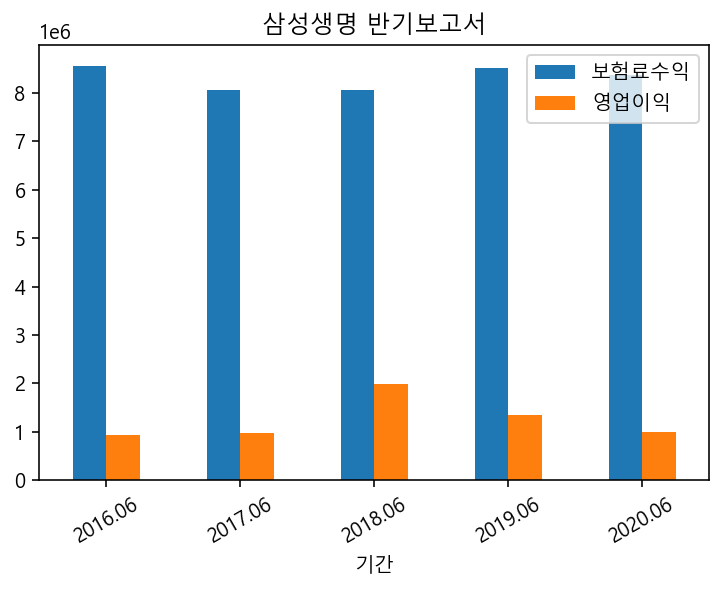

In [40]:
df_selected.plot.bar(rot = 30).set_title('{} {}'.format(corp_nm, report_type_selected))

### 컬럼 내 수치 데이터 수정 및 numeric으로 변경

In [ ]:
# 전체 컬럼에 아래 라인 적용한 후 모든 1: 이후 컬럼 뉴메릭으로 변경한 뒤 데이터 분석 가능.